In [4]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Loading FULL dataset...")

# PATH TO YOUR FULL DATASET
full_data_file = r"C:\Users\me\OneDrive\Documents\Research\AIDA3\NL2UD2TL\Output\output_ground_truth_props_independent.json"

# Load the data
with open(full_data_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Handle if it's a single dict vs list
if isinstance(data, dict):
    data = [data]

print(f"Loaded {len(data)} records from FULL dataset")

Loading FULL dataset...
Loaded 7003 records from FULL dataset


In [6]:
def extract_stl_operator(record):
    """Extract the root STL operator from the record"""
    
    operators = ['G', 'F', 'U', '->', '&', '|', '!', '<=', '>=', '<', '>']
    
    # Method 1: From stl_components
    stl_components = record.get('stl_components', [])
    if stl_components and len(stl_components) > 0:
        if isinstance(stl_components[0], dict):
            op = stl_components[0].get('operator', None)
            if op:
                return op
    
    # Method 2: From stl field
    stl = record.get('stl', '')
    if stl:
        for op in operators:
            if op in stl:
                return op
    
    # Method 3: From ground_truth_stl
    gt_stl = record.get('ground_truth_stl', '')
    if gt_stl:
        for op in operators:
            if op in gt_stl:
                return op
    
    return None

def extract_udr_patterns(record):
    """Extract UDR pattern indicators from record"""
    
    # Initialize all patterns to 0
    pattern_indicators = {
        'UDR1_AnyTimeGlobal': 0,
        'UDR2_BecomeChange': 0,
        'UDR3_BoundedAfter': 0,
        'UDR4_Always': 0,
        'UDR5_Eventually': 0,
        'UDR6_BoundedFor': 0,
        'UDR7_BoundedWithin': 0,
        'UDR8_IfThen': 0,
        'UDR9_NegatedAlways': 0,
        'UDR10_NoLonger': 0,
        'UDR11_Until': 0,
        'UDR12_WhenFirst': 0
    }
    
    # Check patterns field
    patterns = record.get('patterns', [])
    for pattern in patterns:
        if isinstance(pattern, dict) and 'pattern_id' in pattern:
            pattern_id = pattern['pattern_id']
            
            # Map pattern_id to indicator
            if pattern_id == 'pattern_1':
                pattern_indicators['UDR1_AnyTimeGlobal'] = 1
            elif pattern_id == 'pattern_2':
                pattern_indicators['UDR2_BecomeChange'] = 1
            elif pattern_id == 'pattern_3':
                pattern_indicators['UDR3_BoundedAfter'] = 1
            elif pattern_id == 'pattern_4':
                pattern_indicators['UDR4_Always'] = 1
            elif pattern_id == 'pattern_5':
                pattern_indicators['UDR5_Eventually'] = 1
            elif pattern_id == 'pattern_6':
                pattern_indicators['UDR6_BoundedFor'] = 1
            elif pattern_id == 'pattern_7':
                pattern_indicators['UDR7_BoundedWithin'] = 1
            elif pattern_id == 'pattern_8':
                pattern_indicators['UDR8_IfThen'] = 1
            elif pattern_id == 'pattern_9':
                pattern_indicators['UDR9_NegatedAlways'] = 1
            elif pattern_id == 'pattern_10':
                pattern_indicators['UDR10_NoLonger'] = 1
            elif pattern_id == 'pattern_11':
                pattern_indicators['UDR11_Until'] = 1
            elif pattern_id == 'pattern_12':
                pattern_indicators['UDR12_WhenFirst'] = 1
    
    return pattern_indicators

# Process all records
print("\nExtracting features and targets from FULL dataset...")
X_data = []
y_data = []
skipped = 0

for i, record in enumerate(data):
    if i % 1000 == 0:
        print(f"  Processing record {i}/{len(data)}...")
    
    # Get STL operator
    stl_op = extract_stl_operator(record)
    
    if stl_op is None:
        skipped += 1
        continue
    
    # Get UDR patterns
    patterns = extract_udr_patterns(record)
    
    # Add to dataset
    X_data.append(list(patterns.values()))
    y_data.append(stl_op)

# Convert to arrays
X = np.array(X_data)
y = np.array(y_data)
feature_names = list(extract_udr_patterns(data[0]).keys())

print(f"\nExtracted {len(X)} samples with features")
print(f"Skipped {skipped} records without identifiable STL operator")
print(f"Feature dimensions: {X.shape}")
print(f"Unique STL operators: {np.unique(y)}")

# Show distribution
stl_counts = pd.Series(y).value_counts()
print("\nSTL operator distribution:")
for op, count in stl_counts.items():
    print(f"  {op:5}: {count:5} ({count/len(y)*100:.1f}%)")

# Show UDR pattern distribution
pattern_counts = X.sum(axis=0)
print("\nUDR pattern distribution:")
for i, name in enumerate(feature_names):
    print(f"  {name:25}: {pattern_counts[i]:5} occurrences")


Extracting features and targets from FULL dataset...
  Processing record 0/7003...
  Processing record 1000/7003...
  Processing record 2000/7003...
  Processing record 3000/7003...
  Processing record 4000/7003...
  Processing record 5000/7003...
  Processing record 6000/7003...
  Processing record 7000/7003...

Extracted 6611 samples with features
Skipped 392 records without identifiable STL operator
Feature dimensions: (6611, 12)
Unique STL operators: ['!' '&' '->' '<=' '>=' 'F' 'G' 'G!' 'U' '|']

STL operator distribution:
  G    :  2944 (44.5%)
  F    :  1947 (29.5%)
  ->   :   478 (7.2%)
  <=   :   327 (4.9%)
  &    :   315 (4.8%)
  >=   :   221 (3.3%)
  !    :   146 (2.2%)
  U    :   111 (1.7%)
  |    :   106 (1.6%)
  G!   :    16 (0.2%)

UDR pattern distribution:
  UDR1_AnyTimeGlobal       :   662 occurrences
  UDR2_BecomeChange        :     0 occurrences
  UDR3_BoundedAfter        :    32 occurrences
  UDR4_Always              :  4136 occurrences
  UDR5_Eventually          : 

In [7]:
# Split data (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train model
print("\nTraining multinomial logistic regression on FULL dataset...")
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle imbalanced classes
)

model.fit(X_train, y_train)


Training set: 5288 samples
Test set: 1323 samples

Training multinomial logistic regression on FULL dataset...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [8]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Accuracy
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"\nModel Performance:")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Testing accuracy: {test_acc:.3f}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))


Model Performance:
Training accuracy: 0.649
Testing accuracy: 0.630

Classification Report (Test Set):
              precision    recall  f1-score   support

           !       0.30      0.28      0.29        29
           &       0.25      0.03      0.06        63
          ->       0.49      0.76      0.60        96
          <=       0.00      0.00      0.00        66
          >=       0.00      0.00      0.00        44
           F       0.90      0.72      0.80       390
           G       0.81      0.74      0.77       589
          G!       0.23      1.00      0.38         3
           U       0.16      0.95      0.27        22
           |       0.05      0.33      0.09        21

    accuracy                           0.63      1323
   macro avg       0.32      0.48      0.32      1323
weighted avg       0.68      0.63      0.64      1323



In [9]:
# Create coefficient DataFrame
coef_df = pd.DataFrame(
    model.coef_,
    index=model.classes_,
    columns=feature_names
)

print("\n" + "="*80)
print("REGRESSION COEFFICIENTS ANALYSIS")
print("="*80)
print("Positive coefficient = Pattern increases likelihood of STL operator")
print("Negative coefficient = Pattern decreases likelihood of STL operator")

# For each STL operator, show which patterns predict it
for stl_op in model.classes_:
    print(f"\n--- STL Operator: {stl_op} ---")
    coefs = coef_df.loc[stl_op].sort_values(ascending=False)
    
    # Show strong positive predictors
    positive = coefs[coefs > 0.1]
    if len(positive) > 0:
        print("Strong positive predictors:")
        for pattern, coef in positive.items():
            print(f"  {pattern:25}: {coef:+6.3f}")
    
    # Show strong negative predictors
    negative = coefs[coefs < -0.1]
    if len(negative) > 0:
        print("Strong negative predictors:")
        for pattern, coef in negative.items():
            print(f"  {pattern:25}: {coef:+6.3f}")


REGRESSION COEFFICIENTS ANALYSIS
Positive coefficient = Pattern increases likelihood of STL operator
Negative coefficient = Pattern decreases likelihood of STL operator

--- STL Operator: ! ---
Strong positive predictors:
  UDR1_AnyTimeGlobal       : +0.478
Strong negative predictors:
  UDR9_NegatedAlways       : -0.256
  UDR11_Until              : -0.715
  UDR4_Always              : -1.451
  UDR5_Eventually          : -1.515
  UDR8_IfThen              : -1.659

--- STL Operator: & ---
Strong positive predictors:
  UDR3_BoundedAfter        : +0.652
  UDR1_AnyTimeGlobal       : +0.395
  UDR7_BoundedWithin       : +0.289
Strong negative predictors:
  UDR4_Always              : -0.234
  UDR5_Eventually          : -0.252
  UDR8_IfThen              : -0.511
  UDR11_Until              : -0.652
  UDR9_NegatedAlways       : -0.721

--- STL Operator: -> ---
Strong positive predictors:
  UDR8_IfThen              : +4.556
  UDR3_BoundedAfter        : +0.806
  UDR1_AnyTimeGlobal       : +0.103
St

In [10]:
print("\n" + "="*80)
print("VALIDATION: Expected Pattern → STL Mappings")
print("="*80)

# Define expected mappings based on your table
expected_mappings = {
    'UDR1_AnyTimeGlobal': 'G',
    'UDR3_BoundedAfter': 'F',  # F[k,∞]
    'UDR4_Always': 'G',
    'UDR5_Eventually': 'F',
    'UDR7_BoundedWithin': 'F',  # F[0,k]
    'UDR8_IfThen': '->',
    'UDR9_NegatedAlways': '!',  # ¬G
    'UDR11_Until': 'U'
}

print("\nExpected mappings and their coefficients:")
for pattern, expected_stl in expected_mappings.items():
    if expected_stl in model.classes_:
        coef = coef_df.loc[expected_stl, pattern]
        print(f"\n{pattern:25} → {expected_stl:3}")
        print(f"  Coefficient: {coef:+6.3f}")
        if coef > 0:
            print(f"  ✓ Positive (pattern correctly predicts STL)")
        else:
            print(f"  ✗ Non-positive (unexpected)")


VALIDATION: Expected Pattern → STL Mappings

Expected mappings and their coefficients:

UDR1_AnyTimeGlobal        → G  
  Coefficient: +0.023
  ✓ Positive (pattern correctly predicts STL)

UDR3_BoundedAfter         → F  
  Coefficient: +0.434
  ✓ Positive (pattern correctly predicts STL)

UDR4_Always               → G  
  Coefficient: +5.185
  ✓ Positive (pattern correctly predicts STL)

UDR5_Eventually           → F  
  Coefficient: +5.863
  ✓ Positive (pattern correctly predicts STL)

UDR7_BoundedWithin        → F  
  Coefficient: +0.662
  ✓ Positive (pattern correctly predicts STL)

UDR8_IfThen               → -> 
  Coefficient: +4.556
  ✓ Positive (pattern correctly predicts STL)

UDR9_NegatedAlways        → !  
  Coefficient: -0.256
  ✗ Non-positive (unexpected)

UDR11_Until               → U  
  Coefficient: +6.264
  ✓ Positive (pattern correctly predicts STL)


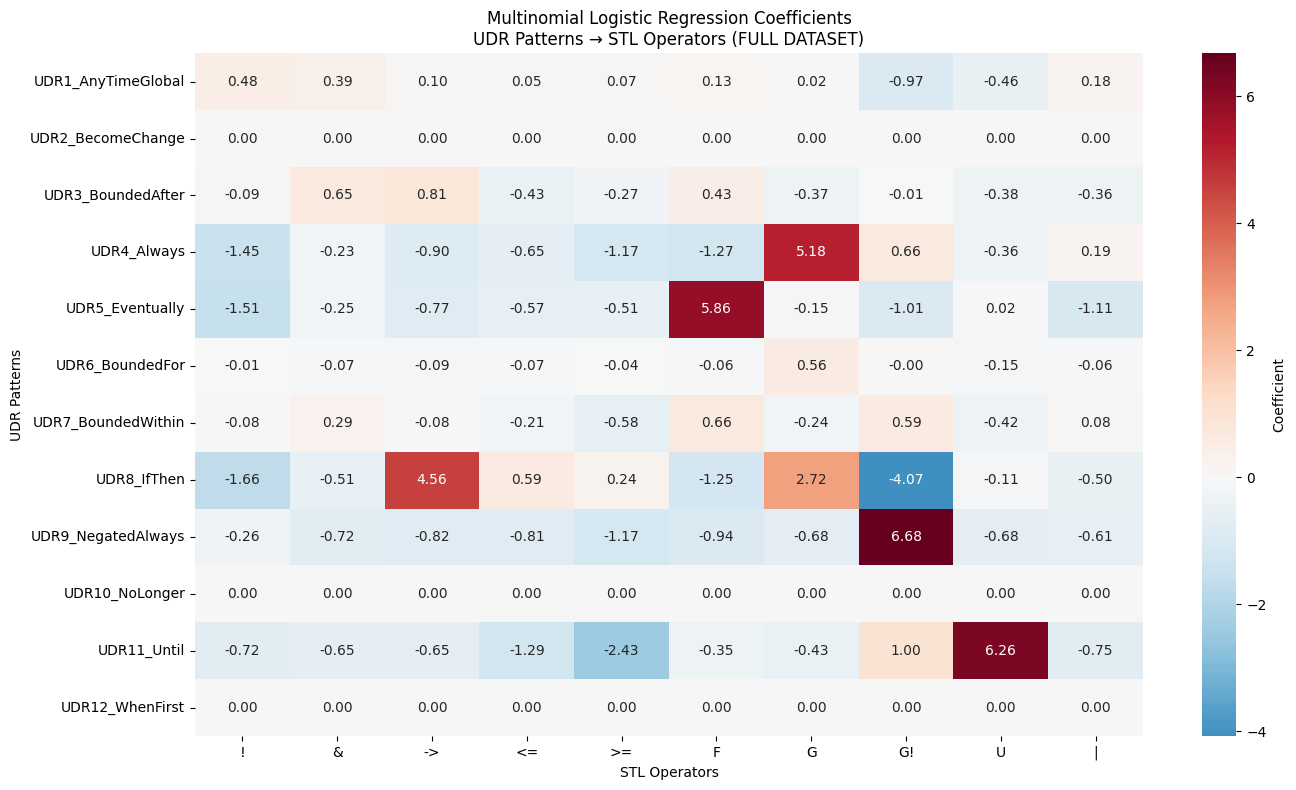

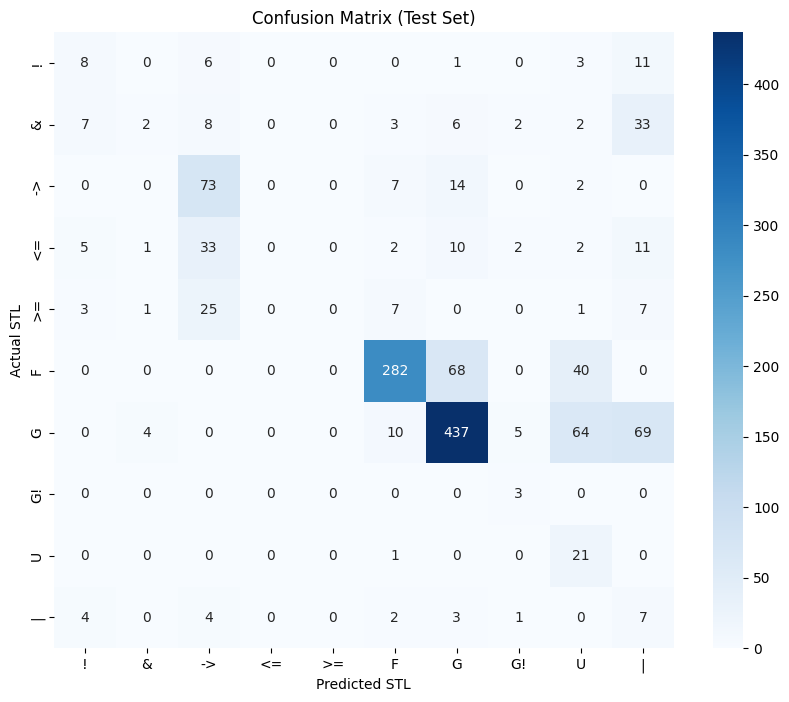

In [11]:
# Coefficient heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(coef_df.T, cmap='RdBu_r', center=0, 
            annot=True, fmt='.2f', cbar_kws={'label': 'Coefficient'})
plt.title('Multinomial Logistic Regression Coefficients\nUDR Patterns → STL Operators (FULL DATASET)')
plt.xlabel('STL Operators')
plt.ylabel('UDR Patterns')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted STL')
plt.ylabel('Actual STL')
plt.show()

In [12]:
print("\n" + "="*80)
print("PREDICTION EXAMPLES")
print("="*80)

def predict_stl(pattern_name):
    """Predict STL for a single UDR pattern"""
    example = np.zeros((1, len(feature_names)))
    idx = feature_names.index(pattern_name)
    example[0, idx] = 1
    
    pred = model.predict(example)[0]
    proba = model.predict_proba(example)[0]
    
    print(f"\nWhen {pattern_name} is detected:")
    print(f"Predicted STL: {pred}")
    print("Probability distribution:")
    for i, stl in enumerate(model.classes_):
        print(f"  P(STL={stl:3}): {proba[i]:.3f}")
    
    return pred, proba

# Test key patterns
test_patterns = ['UDR4_Always', 'UDR5_Eventually', 'UDR11_Until', 'UDR8_IfThen']
for pattern in test_patterns:
    if pattern in feature_names:
        predict_stl(pattern)

print("\n" + "="*80)
print("ANALYSIS COMPLETE USING FULL DATASET!")
print("="*80)
print(f"Total samples used: {len(X)}")
print(f"Model trained on: {len(X_train)} samples")
print(f"Model tested on: {len(X_test)} samples")


PREDICTION EXAMPLES

When UDR4_Always is detected:
Predicted STL: |
Probability distribution:
  P(STL=!  ): 0.186
  P(STL=&  ): 0.205
  P(STL=-> ): 0.003
  P(STL=<= ): 0.119
  P(STL=>= ): 0.114
  P(STL=F  ): 0.002
  P(STL=G  ): 0.075
  P(STL=G! ): 0.004
  P(STL=U  ): 0.003
  P(STL=|  ): 0.290

When UDR5_Eventually is detected:
Predicted STL: F
Probability distribution:
  P(STL=!  ): 0.055
  P(STL=&  ): 0.063
  P(STL=-> ): 0.001
  P(STL=<= ): 0.041
  P(STL=>= ): 0.069
  P(STL=F  ): 0.744
  P(STL=G  ): 0.000
  P(STL=G! ): 0.000
  P(STL=U  ): 0.001
  P(STL=|  ): 0.025

When UDR11_Until is detected:
Predicted STL: U
Probability distribution:
  P(STL=!  ): 0.141
  P(STL=&  ): 0.049
  P(STL=-> ): 0.001
  P(STL=<= ): 0.023
  P(STL=>= ): 0.012
  P(STL=F  ): 0.002
  P(STL=G  ): 0.000
  P(STL=G! ): 0.002
  P(STL=U  ): 0.729
  P(STL=|  ): 0.041

When UDR8_IfThen is detected:
Predicted STL: ->
Probability distribution:
  P(STL=!  ): 0.077
  P(STL=&  ): 0.079
  P(STL=-> ): 0.317
  P(STL=<= ): 0.21